# week 11: Recurrent neural network (part 1)

## 0. Introduction

本次实验设计主要修改自Pytorch官方提供的教程，在官方的教程上进行了整合。如对本次课件的内容有任何疑惑的同学可以直接微信我或者邮件到cuizhiying.csu@gmail.com    
**原作者**: `Sean Robertson <https://github.com/spro/practical-

### 0.1 Experimental content and requirements
本次实验内容主要分为词语分类和词语生成两大部分，具体要求如下：
1. 体验语义分割网络的运行过程，和基本的代码结构，结合理论课的内容，加深对RNN的思考和理解
2. 独立完成实验指导书中提出的问题（简要回答）
3. 按照实验指导书的引导，填充缺失部分的代码，让程序顺利地运转起来
4. 坚持独立完成，**禁止抄袭**
5. 实验结束后，将整个文件夹下载下来（注意保留程序运行结果），打包上传到超算课堂网站中（统一使用zip格式压缩）。



### 0.2 Recommended Reading

These are all good additions to the understanding of RNN.:

-  [The Unreasonable Effectiveness of Recurrent Neural
   Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/)
   shows a bunch of real life examples
-  [Understanding LSTM
   Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
   is about LSTMs specifically but also informative about RNNs in
   general

### 0.3 Setup CUDA

我们在没有CUDA的情况下跑整个实验，但是有CUDA的话自然会更好，首先，检查和配置CUDA环境。

In [41]:
import torch
is_cuda = True if torch.cuda.is_available() else False
print(is_cuda)

True


选着一张空闲的卡

In [42]:
id = 0
torch.cuda.set_device(id)
print( torch.cuda.current_device() )

0



## 1. Classifying Names with a Character-Level RNN
*********************************************
We will be building and training a basic character-level RNN to classify
words. A character-level RNN reads words as a series of characters -
outputting a prediction and "hidden state" at each step, feeding its
previous hidden state into each next step. We take the final prediction
to be the output, i.e. which class the word belongs to.

Specifically, we'll train on a few thousand surnames from 18 languages
of origin, and predict which language a name is from based on the
spelling:




### 1.1 Preparing the Data

Download the data from [here](https://download.pytorch.org/tutorial/data.zip) and extract it to the current directory.

Included in the ``data/names`` directory are 18 text files named as
"[Language].txt". Each file contains a bunch of names, one name per
line, mostly romanized (but we still need to convert from Unicode to
ASCII).

We'll end up with a dictionary of lists of names per language,
``{language: [names ...]}``. The generic variables "category" and "line"
(for language and name in our case) are used for later extensibility.



In [62]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
all_categories = []
category_lines = {}

# Split it into training set and validation set
training_lines = {}
validation_lines = {}

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
    
    num_of_training_set = int(len(lines)*0.8)
    training_lines[category]   = lines[:num_of_training_set]
    validation_lines[category] = lines[num_of_training_set:] 

n_categories = len(all_categories)
print(n_categories)

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']
Slusarski
18


Now we have ``category_lines``, a dictionary mapping each category
(language) to a list of lines (names). We also kept track of
``all_categories`` (just a list of languages) and ``n_categories`` for
later reference.




In [63]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


### 1.2 Turning Names into Tensors


Now that we have all the names organized, we need to turn them into
Tensors to make any use of them.

To represent a single letter, we use a "one-hot vector" of size
``<1 x n_letters>``. A one-hot vector is filled with 0s except for a 1
at index of the current letter, e.g. ``"b" = <0 1 0 0 0 ...>``.

To make a word we join a bunch of those into a 2D matrix
``<line_length x 1 x n_letters>``.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we're just using a batch size of 1 here.




In [64]:
import torch


# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    if is_cuda:
        tensor = tensor.cuda()
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    if is_cuda:
        tensor = tensor.cuda()
    return tensor

# Tensor here, someone else may call it vector. 
print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]], device='cuda:0')
torch.Size([5, 1, 57])


### 1.3 Creating the Network


Before autograd, creating a recurrent neural network in Torch involved
cloning the parameters of a layer over several timesteps. The layers
held hidden state and gradients which are now entirely handled by the
graph itself. This means you can implement a RNN in a very "pure" way,
as regular feed-forward layers.

Inside the forward function, we need to Loop 


<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png" width = "50%" />






In [65]:
import torch.nn as nn

class BaseRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(BaseRNN, self).__init__()

        self.hidden_size = hidden_size

        # input to hidden
        self.i2h = nn.Linear(input_size,  hidden_size)
        # hidden to hidden
        self.h2h = nn.Linear(hidden_size, hidden_size)
        #############################################
        #
        #  Change your activation function here
        #
        #############################################
        # self.activation = nn.Tanh()
        self.activation = nn.ReLU()
        # hidden to output
        self.h2o = nn.Linear(hidden_size, output_size)
        
    def step(self, letter, hidden):
        i2h = self.i2h(letter)
        h2h = self.h2h(hidden)
        hidden = self.activation( h2h+i2h )
        
        output = self.h2o(hidden)
        return output, hidden
    
    def forward(self, word):
        hidden = self.initHidden(is_cuda)
        for i in range(word.size()[0]):
            # Only the last output will be used to predict
            output, hidden = self.step(word[i], hidden)
        return output
    
    def initHidden(self, is_cuda=True):
        if is_cuda:
            return torch.zeros(1, self.hidden_size).cuda()
        else:
            return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = BaseRNN(n_letters, n_hidden, n_categories)
if is_cuda:
    rnn = rnn.cuda()

In [66]:
###############################################################################
#
# Finish a the following model, and train it
#
###############################################################################

class DeeperRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(DeeperRNN, self).__init__()
        self.hidden1_size = hidden_size
        self.hidden2_size = hidden_size
        self.layer1 = BaseRNN(input_size, hidden_size, hidden_size)
        self.layer2 = BaseRNN(hidden_size, hidden_size, output_size)
        
    def step(self, letter, hidden1, hidden2):
        ############################################################
        
        # complete this function
        
        ############################################################
        output1, hidden1 = self.layer1.step(letter, hidden1)
        output2, hidden2 = self.layer2.step(output1, hidden2)
        
        return output2, hidden1, hidden2
    
    def forward(self, word):
        ############################################################
        
        # complete this function
        
        ############################################################
        hidden1,hidden2 = self.initHidden(is_cuda)
        for i in range(word.size()[0]):
            output, hidden1, hidden2 = self.step(word[i], hidden1, hidden2)
        
        return output

        
    def initHidden(self, is_cuda=True):
        if is_cuda:
            return torch.zeros(1, self.hidden1_size).cuda(), torch.zeros(1, self.hidden2_size).cuda()
        else:
            return torch.zeros(1, self.hidden1_size), torch.zeros(1, self.hidden2_size)

###############################################################################

# Remember to uncomment the following two line after you finish your model and
# start to retrain your model

###############################################################################
n_hidden = 128
rnn = DeeperRNN(n_letters, n_hidden, n_categories)
rnn = rnn.cuda() if is_cuda else rnn

To run a step of this network we need to pass an input (in our case, the
Tensor for the current letter) and a previous hidden state (which we
initialize as zeros at first). We'll get back the output (probability of
each language) and a next hidden state (which we keep for the next
step).




In [67]:
input = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)
hidden = hidden.cuda() if is_cuda else hidden

output, next_hidden = rnn.step(input, hidden)
print(output.shape)
print(next_hidden.shape)

TypeError: step() missing 1 required positional argument: 'hidden2'

For the sake of efficiency we don't want to be creating a new Tensor for
every step, so we will use ``lineToTensor`` instead of
``letterToTensor`` and use slices. This could be further optimized by
pre-computing batches of Tensors.


Each loop in side forward function will:

-  Create input and target tensors
-  Create a zeroed initial hidden state
-  Read each letter in and

   -  Keep hidden state for next letter

-  Compare final output to target
-  Back-propagate
-  Return the output and loss

In [68]:
input = lineToTensor('Albert')
print(n_hidden)

output = rnn(input)
print(output)
print(output.shape)

128
tensor([[-0.0299, -0.1732,  0.0620, -0.1280, -0.1184,  0.0628, -0.0525, -0.0835,
          0.1273,  0.0463,  0.0287,  0.0202, -0.0659,  0.1102, -0.0144,  0.0275,
         -0.0311,  0.0937]], device='cuda:0', grad_fn=<AddmmBackward>)
torch.Size([1, 18])


As you can see the output is a ``<1 x n_categories>`` Tensor, where
every item is the likelihood of that category (higher is more likely).




### 1.4 Training

#### 1.4.1 Preparing for Training
Before going into training we should make a few helper functions. The
first is to interpret the output of the network, which we know to be a
likelihood of each category. We can use ``Tensor.topk`` to get the index
of the greatest value:




In [69]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Irish', 8)


We will also want a quick way to get a training example (a name and its
language):




In [70]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    # attention: split training set 
    line = randomChoice(training_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    category_tensor = category_tensor.cuda() if is_cuda else category_tensor
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

def randomValidationExample():
    category = randomChoice(all_categories)
    # attention: split validation set
    line = randomChoice(validation_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    category_tensor = category_tensor.cuda() if is_cuda else category_tensor
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = English / line = Gibbs
category = Russian / line = Anufriev
category = Irish / line = Connolly
category = German / line = Schultheiss
category = German / line = Messmann
category = Vietnamese / line = Lac
category = Japanese / line = Shimaoka
category = Arabic / line = Shalhoub
category = Dutch / line = Rooiakker
category = Scottish / line = Anderson


#### 1.4.2 Training the Network

Now all it takes to train this network is show it a bunch of examples,
have it make guesses, and tell it if it's wrong.





In [71]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn


def train(category_tensor, line_tensor):
    output = rnn(line_tensor)
    rnn.zero_grad()
    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        if hasattr(p.grad, "data"):
            p.data.add_(-learning_rate, p.grad.data)


    return output, loss.item()

Now we just have to run that with a bunch of examples. Since the
``train`` function returns both the output and loss we can print its
guesses and also keep track of loss for plotting. Since there are 1000s
of examples we print only every ``print_every`` examples, and take an
average of the loss.




In [72]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (1m 50s) 2.7672 Meeuwissen / Dutch ✓
10000 10% (3m 43s) 2.2076 Ibanez / Czech ✗ (Spanish)
15000 15% (5m 36s) 2.6768 Bernard / English ✗ (French)
20000 20% (7m 25s) 2.2216 Garrastazu / Italian ✗ (Spanish)
25000 25% (9m 14s) 1.4868 Lieu / Chinese ✗ (Vietnamese)
30000 30% (11m 5s) 1.1129 Doan / Chinese ✗ (Vietnamese)
35000 35% (12m 53s) 0.0093 Katsukawa / Japanese ✓
40000 40% (14m 44s) 0.0123 Fotiev / Russian ✓
45000 45% (16m 35s) 0.8205 Lillis / Greek ✓
50000 50% (18m 27s) 0.4914 Bartosz / Polish ✓
55000 55% (20m 19s) 0.9217 Drassal / Polish ✗ (Czech)
60000 60% (22m 11s) 1.9323 Percival / French ✗ (English)
65000 65% (24m 3s) 0.0273 Ferreiro / Portuguese ✓
70000 70% (25m 57s) 1.2591 Cerv / Czech ✓
75000 75% (27m 50s) 0.0409 Dinh / Vietnamese ✓
80000 80% (29m 44s) 0.2713 Arreola / Spanish ✓
85000 85% (31m 36s) 0.0013 Arvanitoyannis / Greek ✓
90000 90% (33m 27s) 0.0559 Mischikhin / Russian ✓
95000 95% (35m 18s) 0.0467 Guillory / French ✓
100000 100% (37m 7s) 0.2523 Leeuwenhoek / Du

#### 1.4.3 Plotting the Results
--------------------

Plotting the historical loss from ``all_losses`` shows the network
learning:




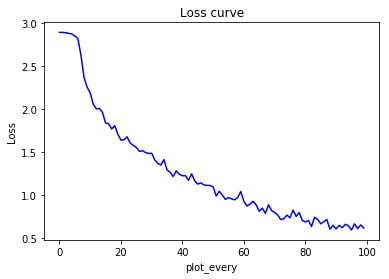

In [73]:
import matplotlib.pyplot as plt
import numpy as np
x = np.array(range(len(all_losses)))
y0 = np.array(all_losses)
plt.plot(x, y0, c='b')
plt.axis()
plt.title('{} curve'.format('Loss'))
plt.xlabel('plot_every')
plt.ylabel('{}'.format('Loss'))
plt.show()


### 1.5 Evaluating the Results

To see how well the network performs on different categories, we will
create a confusion matrix, indicating for every actual language (rows)
which language the network guesses (columns). To calculate the confusion
matrix a bunch of samples are run through the network with
``evaluate()``, which is the same as ``train()`` minus the backprop.




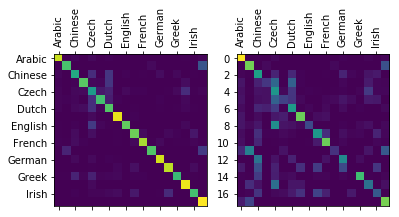

Traing set Acc is 0.7897999882698059
validation set Acc is 0.45500001311302185


In [74]:
# Keep track of correct guesses in a confusion matrix
confusion_training   = torch.zeros(n_categories, n_categories)
confusion_validation = torch.zeros(n_categories, n_categories)
n_confusion = 5000

# Just return an output given a line
def evaluate(line_tensor):
    rnn.eval()
    output = rnn(line_tensor)
    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion_training[category_i][guess_i] += 1

    
# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomValidationExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion_validation[category_i][guess_i] += 1
    
    
# catcul acc
right_train = 0
right_valid = 0
for i in range(n_categories):
    right_train += confusion_training[i][i]
    right_valid += confusion_validation[i][i]
acc_train = right_train / n_confusion
acc_valid = right_valid / n_confusion

# Normalize by dividing every row by its sum and 
for i in range(n_categories):
    confusion_training[i] = confusion_training[i] / confusion_training[i].sum()
    confusion_validation[i] = confusion_validation[i] / confusion_validation[i].sum()


# Set up plot
fig = plt.figure()
ax1 = fig.add_subplot(121)
cax1 = ax1.matshow(confusion_training.numpy())

ax2 = fig.add_subplot(122)
cax2 = ax2.matshow(confusion_validation.numpy())


# Set up axes
ax1.set_xticklabels([''] + all_categories, rotation=90)
ax1.set_yticklabels([''] + all_categories)
ax2.set_xticklabels([''] + all_categories, rotation=90)

# sphinx_gallery_thumbnail_number = 2
plt.show()

print("Traing set Acc is", acc_train.item())
print("validation set Acc is", acc_valid.item())

You can pick out bright spots off the main axis that show which
languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish
for Italian. It seems to do very well with Greek, and very poorly with
English (perhaps because of overlap with other languages).




### 1.6 Running on User Input





In [32]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))
        output = torch.nn.functional.softmax(output, dim=1)

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('Probability (%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict("Cui")
predict("Zhuang")
predict("Xue")
predict("Wang")
predict("Peng")
predict("Wei")
predict("Lin")


> Dovesky
Probability (0.57) Czech
Probability (0.40) Russian
Probability (0.02) English

> Jackson
Probability (0.61) English
Probability (0.19) Czech
Probability (0.13) Russian

> Satoshi
Probability (0.98) Japanese
Probability (0.01) Arabic
Probability (0.01) Italian

> Cui
Probability (0.79) Vietnamese
Probability (0.16) Chinese
Probability (0.02) Italian

> Zhuang
Probability (0.46) Chinese
Probability (0.45) Vietnamese
Probability (0.09) Korean

> Xue
Probability (0.75) Chinese
Probability (0.16) Vietnamese
Probability (0.04) Korean

> Wang
Probability (0.53) Korean
Probability (0.43) Chinese
Probability (0.02) German

> Peng
Probability (0.78) Chinese
Probability (0.09) German
Probability (0.04) Korean

> Wei
Probability (0.94) Chinese
Probability (0.03) Korean
Probability (0.02) Vietnamese

> Lin
Probability (0.67) Chinese
Probability (0.21) Korean
Probability (0.03) Irish


### 1.7 Exercises
==============================================================================================================

1、在第`1.4.3`节中编写代码，打印出训练过程当中，loss值的变化，（loss已经在训练过程中记录，找出并画成曲线即可，你也可以选择自己修改训练过程中的代码，自己实现重新画成更加漂亮的曲线。）   
   
2、在第`1.6`节，将自己的姓名的每一个字的拼音输入进去，进行预测，看模型预测是否正确（保留上面的预测结果）。如名字为`张三`，则输入`predict('Zhang')`和`predict('San')`.   

3、编辑该cell，在下面一行回答问题。当前的`BaseRNN`中使用的激活函数修改成`relu`（在第1.3小节中），然后重新训练模型，看性能是否有变化。

当前的激活函数是（  Tanh    ），训练集准确率为：（  0.7674000263214111          ）验证集的准确率为：（    0.37959998846054077             ）  
激活函数为`Relu`时的训练准确率为：（      0.7868000268936157      ）验证集的准确率为：（     0.4551999866962433            ）

4、编辑该cell，在下面一行记录当前的模型的准确率，然后，回到1.3中，编辑`DeeperRNN`类，使其比`BaseRNN`类更深一层，并且重新训练这个更深的网络，看新能是否有提高（记得去掉`DeeperRNN`那一个cell中的最后两行的注释）。对于RNN的隐藏层的增加可阅读下一个cell的补充理解

`BaseRNN`的训练集准确率为：（     0.7868000268936157       ）验证集的准确率为：（      0.4551999866962433           ）  
`DeeperRNN`的训练准确率为：（     0.7897999882698059       ）验证集的准确率为：（       0.45500001311302185          ）    


补充材料：    
>RNNs are neural networks and everything works monotonically better (if done right) if you put on your deep learning hat and start stacking models up like pancakes. For instance, we can form a 2-layer recurrent network as follows:
``` python
y1 = rnn1.step(x)
y = rnn2.step(y1)
```
>In other words we have two separate RNNs: One RNN is receiving the input vectors and the second RNN is receiving the output of the first RNN as its input. Except neither of these RNNs know or care - it’s all just vectors coming in and going out, and some gradients flowing through each module during backpropagation.

原文阅读点击[这里](https://karpathy.github.io/2015/05/21/rnn-effectiveness/)

多层hidden网络结构图如下图所示，其中虚线输出的output表示改output值被丢弃，没有进一步使用：

<img src="./images/multihidden.png" width = "40%" />

## 2. Generating Names with a Character-Level RNN
******************************************************    
We are still hand-crafting a small RNN with a few linear layers. The big
difference is instead of predicting a category after reading in all the
letters of a name, we input a category and output one letter at a time.
Recurrently predicting characters to form language (this could also be
done with words or other higher order constructs) is often referred to
as a "language model".

## 2.1 Creating the Network


This network extends [the last tutorial's RNN](#Creating-the-Network)
with an extra argument for the category tensor, which is added
with the others. The category tensor is a one-hot vector just like
the letter input.

We will interpret the output as the probability of the next letter. When
sampling, the most likely output letter is used as the next input
letter.

I added a second linear layer ``h2o`` (after combining hidden and
output) to give it more muscle to work with. There's also a dropout
layer, which [randomly zeros parts of its
input](https://arxiv.org/abs/1207.0580) with a given probability
(here 0.2) and is usually used to fuzz inputs to prevent overfitting.
Here we're using it towards the end of the network to purposely add some
chaos and increase sampling variety.

<img src="./images/grnn.png" width = "40%" />






In [107]:
import torch
import torch.nn as nn

class GenerateRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GenerateRNN, self).__init__()
        self.hidden_size = hidden_size
        self.c2h = nn.Linear(n_categories, hidden_size)
        self.i2h = nn.Linear(input_size,   hidden_size)
        self.h2h = nn.Linear(hidden_size,  hidden_size)
        self.activation = nn.Tanh()
        self.h2o = nn.Linear(hidden_size,  output_size)
        self.dropout = nn.Dropout(0.2)

        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        c2h = self.c2h(category)
        i2h = self.i2h(input)
        h2h = self.h2h(hidden)
        
        hidden = self.activation( c2h+i2h+h2h )
        

        dropout = self.dropout(self.h2o(hidden))
        output = self.softmax(dropout)
        return output, hidden

    def initHidden(self, is_cuda=True):
        if is_cuda:
            return torch.zeros(1, self.hidden_size).cuda()
        else:
            return torch.zeros(1, self.hidden_size)

### 2.2 Training
#### 2.2.1 Preparing for Training

In [108]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

For each timestep (that is, for each letter in a training word) the
inputs of the network will be
``(category, current letter, hidden state)`` and the outputs will be
``(next letter, next hidden state)``. So for each training set, we'll
need the category, a set of input letters, and a set of output/target
letters.

Since we are predicting the next letter from the current letter for each
timestep, the letter pairs are groups of consecutive letters from the
line - e.g. for ``"ABCD<EOS>"`` we would create ("A", "B"), ("B", "C"),
("C", "D"), ("D", "EOS").

![figure](https://i.imgur.com/JH58tXY.png)

The category tensor is a [one-hot
tensor](https://en.wikipedia.org/wiki/One-hot) of size
``<1 x n_categories>``. When training we feed it to the network at every
timestep - this is a design choice, it could have been included as part
of initial hidden state or some other strategy.

Or you could look at [here]() for another description. I think this image could
tell you everything.
<img src="./images/charseq.jpeg" width = "50%" />

In [109]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    if is_cuda:
        tensor = tensor.cuda()
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    if is_cuda:
        tensor = tensor.cuda()
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    tensor = torch.LongTensor(letter_indexes)
    if is_cuda:
        tensor = tensor.cuda()
    return tensor

For convenience during training we'll make a ``randomTrainingExample``
function that fetches a random (category, line) pair and turns them into
the required (category, input, target) tensors.


In [110]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

#### 2.2.2 Training the Network

In contrast to classification, where only the last output is used, we
are making a prediction at every step, so we are calculating loss at
every step.

The magic of autograd allows you to simply sum these losses at each step
and call backward at the end.


For the loss function ``nn.NLLLoss`` is appropriate, since the last
layer of the RNN is ``nn.LogSoftmax``.

For the different between `nn.NLLLoss` and the `nn.LogSoftmax`, we could Look
at the source code, the most import line is quote as follow:

``` python
 def cross_entropy(input, target):
    return nll_loss(log_softmax(input, 1))

```

In a word, Cross entropy combines `log_softmax` and `nll_loss` in a single function.


In [111]:
criterion = nn.NLLLoss()

learning_rate = 0.0005


def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden( is_cuda )

    rnn.zero_grad()

    loss = 0

    # Take care of the loss function, 
    # it could be visualized as the following figure 
    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()
    

    for p in rnn.parameters():
        if hasattr(p.grad, "data"):
            p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item() / input_line_tensor.size(0)

The loss function could be shown as the following picture. The network forward through entire sequence to compute loss, then backward through entire sequence to compute gradient
<img src="./images/rnn-loss.png" width = "50%" />


To keep track of how long training takes I am adding a timeSince(timestamp) function which returns a human readable string:

In [112]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

Training is business as usual - call train a bunch of times and wait a few minutes, printing the current time and loss every print_every examples, and keeping store of an average loss per plot_every examples in all_losses for plotting later.

In [113]:
rnn = GenerateRNN(n_letters, 128, n_letters)
rnn = rnn.cuda() if is_cuda else rnn

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, total_loss/iter))

    if iter % plot_every == 0:
        all_losses.append(total_loss / iter)

2m 12s (5000 5%) 3.1507
4m 23s (10000 10%) 3.0293
6m 36s (15000 15%) 2.9638
8m 43s (20000 20%) 2.9183
10m 23s (25000 25%) 2.8805
11m 59s (30000 30%) 2.8489
13m 37s (35000 35%) 2.8221
15m 13s (40000 40%) 2.7975
16m 50s (45000 45%) 2.7782
18m 26s (50000 50%) 2.7612
20m 4s (55000 55%) 2.7451
21m 41s (60000 60%) 2.7296
23m 16s (65000 65%) 2.7146
24m 52s (70000 70%) 2.7022
26m 29s (75000 75%) 2.6906
28m 6s (80000 80%) 2.6795
29m 43s (85000 85%) 2.6680
31m 20s (90000 90%) 2.6578
32m 55s (95000 95%) 2.6481
34m 32s (100000 100%) 2.6398


#### 2.2.3 Plotting the Losses

Plotting the historical loss from all\_losses shows the network
learning:


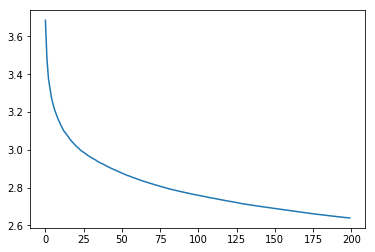

In [116]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

### 2.3 Sampling the Network

To sample we give the network a letter and ask what the next one is,
feed that in as the next letter, and repeat until the EOS token.

-  Create tensors for input category, starting letter, and empty hidden
   state
-  Create a string ``output_name`` with the starting letter
-  Up to a maximum output length,

   -  Feed the current letter to the network
   -  Get the next letter from highest output, and next hidden state
   -  If the letter is EOS, stop here
   -  If a regular letter, add to ``output_name`` and continue

-  Return the final name

**Note:**
   Rather than having to give it a starting letter, another
   strategy would have been to include a "start of string" token in
   training and have the network choose its own starting letter.



In [117]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  
        # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden(is_cuda)

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))
    print("\n")


samples('Russian', 'CCZZYY')

samples('German',  'CCZZYY')

samples('Spanish', 'CCZZYY')

samples('Chinese', 'CCZZYY')

samples('Chinese', 'PPPPPPPPP')

Cherinok
Chanan
Zhanaki
Zhanakov
Yakinov
Yakinovev


Chanerer
Caren
Zersere
Zeren
Yamer
Youne


Canara
Careza
Zoulas
Zoura
Yanaza
Yenaraz


Can
Chan
Zhi
Zhan
Yan
Yan


Pin
Pin
Pan
Pin
Pin
Pan
Pin
Pai
Pan




去掉dropout后的训练结果

In [86]:
class GenerateRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GenerateRNN, self).__init__()
        self.hidden_size = hidden_size
        self.c2h = nn.Linear(n_categories, hidden_size)
        self.i2h = nn.Linear(input_size,   hidden_size)
        self.h2h = nn.Linear(hidden_size,  hidden_size)
        self.activation = nn.Tanh()
        self.h2o = nn.Linear(hidden_size,  output_size)
        self.dropout = nn.Dropout(0.2)

        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        c2h = self.c2h(category)
        i2h = self.i2h(input)
        h2h = self.h2h(hidden)
        
        hidden = self.activation( c2h+i2h+h2h )
        
        output = self.softmax(self.h2o(hidden))
        return output, hidden

    def initHidden(self, is_cuda=True):
        if is_cuda:
            return torch.zeros(1, self.hidden_size).cuda()
        else:
            return torch.zeros(1, self.hidden_size)


rnn = GenerateRNN(n_letters, 128, n_letters)
rnn = rnn.cuda() if is_cuda else rnn

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, total_loss/iter))

    if iter % plot_every == 0:
        all_losses.append(total_loss / iter)

1m 35s (5000 5%) 2.9274
3m 11s (10000 10%) 2.7832
4m 49s (15000 15%) 2.7052
6m 30s (20000 20%) 2.6482
8m 10s (25000 25%) 2.6025
9m 50s (30000 30%) 2.5638
11m 25s (35000 35%) 2.5298
13m 0s (40000 40%) 2.5012
14m 35s (45000 45%) 2.4763
16m 10s (50000 50%) 2.4526
17m 45s (55000 55%) 2.4316
19m 19s (60000 60%) 2.4129
20m 56s (65000 65%) 2.3952
22m 31s (70000 70%) 2.3787
24m 30s (75000 75%) 2.3631
26m 26s (80000 80%) 2.3486
28m 5s (85000 85%) 2.3348
29m 42s (90000 90%) 2.3223
31m 19s (95000 95%) 2.3106
33m 0s (100000 100%) 2.2986


In [87]:
samples('Russian', 'CCZZYY')

samples('German',  'CCZZYY')

samples('Spanish', 'CCZZYY')

samples('Chinese', 'CCZZYY')

samples('Chinese', 'PPPPPPPPP')

Chanton
Chanton
Zanton
Zanton
Yakinov
Yakinov


Cherren
Cherren
Zerter
Zerter
Yanger
Yanger


Carra
Carra
Zara
Zara
Yandara
Yandara


Chang
Chang
Zhan
Zhan
Yan
Yan


Pan
Pan
Pan
Pan
Pan
Pan
Pan
Pan
Pan




## 2.4 Exercises
=======================================================================================================

1、反复输入自己名字的首字母，观察网络的生成的名字是否一样（保留以你自己的名字的首字母为程序输入的结果）  
**答：**网络生成的名字不一样。

2、请回答：为什么这个模型这个模型训练好了之后，输入同样的参数会产生不一样的结果？并在上面的程序中验证你自己的猜测  
**答：**dropout的引入使得输入同样的参数的时候产生不一样的结果，因为dropout的引入使得网络的性能得到泛化。验证如上所示。
3、这是一个生成模型，该模型只输入了一个字母，就可以预测一个单词，请问改模型在开始预测什么时候终止预测新的字符，即这个生成模型是如何确定生成的单词的长度的？  
**答：**在模型预测到的下一个字符是'EOF'的时候终止预测新字符。  

4、根据下一个cell的提示，以impantance sampling的方式，实现程序在同样输入的情况下，可能生成不一样的名字。

Importance sampling指的是，在生成单词每一个字母的时候，一般的生成模型都有是选择输出结果中概率值最大的字母作为预测，而Importance sampling的方式则是按照各个字母的输出概率来选择输出哪个模型。举个栗子，当程序输入一个字母`C`的时候，程序预测下一个字母为`[a, o, e]`的概率分别为`[0.7, 0.2, 0.1]`, 普通的做法是直接选择概率值最大的`a`作为预测结果，而`Importance Sampling`的方式则是以`70%`的概率选择`a`，以`20%`的概率选择`o`，以`10%`的该路选择`e`，最终选到哪个有一定的随机性。
请根据你的理解，补充完成下面的`Importance sampling`的预测。    

Tips: 可使用`numpy.random.choice`函数，文档请点击[这里](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.choice.html)

Tips: 这部分的代码与上面的代码的不同之处仅仅在于如何选取预测值，所以，你只需要在下面指定的区域编辑代码即可。     

Tips: 直接使用模型输出的概率值会比较麻烦，因为模型的概率输出值会很小，因为这里有50多种字符，所以，一个更加明智的做法是只在概率值最高的前3个或者5个中选择，记得要将概率使用softmax等函数将其转换到和为1.     

Tips: 更加简单的做法是，仅仅使用模型输出的概率值进行排序，然后使用指定的概率值进行选择，如，指定选择概率最大的那个字母的概率值为0.5，第二大的为0.3，第三大的为0.2，然后可以直接输入[0.5, 0.3, 0.2].

In [120]:
import numpy as np
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        # initial the model and input
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden(is_cuda)

        output_name = start_letter

        for i in range(max_length):
            # get the output from model
            output, hidden = rnn(category_tensor, input[0], hidden)
            # change it into probability
            output = torch.exp(output)
            
            topv, topi = output.topk(3)
            topv = torch.nn.functional.softmax(topv, dim=1)
            
            _, len1 = topv.shape
            topv_np = np.array(torch.Tensor.cpu(topv)).reshape(len1)
            index = np.random.choice(a = len1, size = 1, replace = False, p = topv_np)[0]
            #################################################################################
            # code here           
            #
            ################################################################################
            topi = topi[0][index]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))
    print("\n")

rnn.eval()

samples('Russian', 'CYY')

samples('German', 'CCY')

samples('Spanish', 'CCZZYY')

samples('Chinese', 'CCCZZZYYY')
samples('Chinese', 'PPPPPPPPP')

Cakovek
Yakantevon
Yinoskiv


Cenguran
Celmen
Yosener


Chanezaze
Counez
Zouloue
Zanezeza
Yolou
Yangeraza


Cung
Chan
Chi
Zinon
Zua
Zhounn
Yie
Yonne
Yaighe


Pie
Pai
Paun
Pien
Paig
Pan
Phie
Pai
Phan


